This script is included in the repo but isn't runnable because of all of the external data sources which we didn't want to replicate

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib as mpl

import numpy as np
import pandas as pd
import pickle as pkl

from scipy.stats import lognorm
from scipy.stats import norm

In [3]:
# Defaults used for ESSD paper

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=False)             #
plt.rcParams['figure.dpi'] = 100         # Display dpi
plt.rcParams['savefig.dpi'] = 300        # Save dpi
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams["axes.titlepad"] = 3.0

Important functions

In [4]:
def r_trans(y):
    y = np.asarray(y)
    return np.exp(((y - a) * (obs_log_max -  obs_log_min) / (b - a)) + obs_log_min)

def reverse_transform_std(y):
    return ((y)*(obs_log_max - obs_log_min) / (b - a))

def recube(in_array):

    plev_len = 52
    lat_len = 36
    time_len = 31 * 12

    output = np.zeros([time_len, plev_len, lat_len])

    for t in range(time_len):
        output[t,:,:] = in_array[plev_len * lat_len * (t): plev_len * lat_len * (t+1)].reshape([plev_len, lat_len])
    
    return output

def interp_to_new_lats(psp, old_lats):
    
    new_lats = lat
    
    interp_psp = []
    for t in range(372):
        interp_psp.append(np.interp(new_lats, old_lats, psp[t]))
    return np.array(interp_psp)
        

In [5]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

Load data

In [6]:
in_dir = './../BNNOutput/'
lat = pkl.load(open(in_dir + 'lats.pkl', 'rb'))
plev = np.unique(pkl.load(open(in_dir + 'plevs.pkl', 'rb'))/100)[::-1]
date = pkl.load(open(in_dir + 'dates.pkl', 'rb'))

num_models = 13
df = pd.read_pickle('./../vmro3_refC1SD_70x36_13mdls_masked_extrap_and_interp.pkl')
plev_orig = np.unique(df['plev'])[::-1]
df = df[df['plev'] < 50000]
df = df[df['plev'] > 30]
obs = df['obs_toz'].copy()
obs[np.log10(obs) < -9] = np.nan
df['obs_toz'] = obs

obs = recube(df['obs_toz'].values)
train_mask = recube(df['train'].values).astype(np.bool)
test_mask = recube(df['test'].values).astype(np.bool)
interp_mask = recube(df['temp_interp'].values).astype(np.bool)
extrap_mask = recube(df['temp_extrap'].values).astype(np.bool)

obs_train = obs.copy()
obs_train[~train_mask] = np.nan
obs_test = obs.copy()
obs_test[~test_mask] = np.nan
obs_interp = obs.copy()
obs_interp[~interp_mask] = np.nan
obs_extrap = obs.copy()
obs_extrap[~extrap_mask] = np.nan

obs_min = df['obs_toz'].min()
obs_max = df['obs_toz'].max()

obs_log_max = np.log(obs_max)
obs_log_min = np.log(obs_min)
a, b = [-1, 1]

# ptp = pkl.load(open('mon_trpp_1980-2010.pkl', 'rb'))
# psp = pkl.load(open('ave_CCMI_psp.pkl', 'rb')) / 100    # psp is in Pa
# ptp = interp_to_new_lats(ptp, np.arange(-90,90.1, 180/72))    # ptp needs regridding

# BNN output
weights = pkl.load(open(in_dir + 'weights.pkl', 'rb'))
bias_raw = pkl.load(open(in_dir + 'bias.pkl', 'rb')) 
noise_raw = pkl.load(open(in_dir + 'noise.pkl', 'rb')) 
std_raw = recube(pkl.load(open(in_dir + 'std.pkl', 'rb')))
pred_raw = recube(pkl.load(open(in_dir + 'pred.pkl', 'rb')))
epi_raw = pkl.load(open(in_dir + 'epi.pkl', 'rb'))

train_data_count = []
for i in range(372):
    train_data_count.append(np.sum(df['train'][df['mons']==i + 1]))
train_data_count = np.array(train_data_count)


/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/3251879044.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_mask = recube(df['train'].values).astype(np.bool)
/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/3251879044.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = recube(df['test'].values).

In [7]:
bdbp_infill = pkl.load(open('BDBP_1.4_1980-2010.pkl', 'rb'))
bdbp_infill = np.transpose(bdbp_infill, axes=(0,2,1))
# Compress obs_infill to match the same pressure levels as we have >30Pa, <50000hPa
# This is correct but could be neatened
i1 = np.where(np.diff(plev_orig > 30))[0][0] + 1
i0 = np.where(np.diff(plev_orig < 50000))[0][0] + 1
bdbp_infill = bdbp_infill[:,  i0:i1, :]

# BAISC gozcards-SWOOSH meged
basic_wos = pkl.load(open('external_data/zmo3_BASIC_v1_without_SBUV.pkl', 'rb'))
basic_wos[basic_wos==0] = np.nan
basic_wos_lat = pkl.load(open('external_data/lat_BASIC_v1_without_SBUV.pkl', 'rb'))
basic_wos_plev = pkl.load(open('external_data/plev_BASIC_v1_without_SBUV.pkl', 'rb'))

# BAISC gozcards-SWOOSH-SBUV meged
basic_ws = pkl.load(open('external_data/zmo3_BASIC_v1_with_SBUV.pkl', 'rb'))
basic_ws[basic_ws==0] = np.nan
basic_ws_lat = pkl.load(open('external_data/lat_BASIC_v1_with_SBUV.pkl', 'rb'))
basic_ws_plev = pkl.load(open('external_data/plev_BASIC_v1_with_SBUV.pkl', 'rb'))
basic_time = pd.date_range(start='1985-01-01', freq='MS', periods=312)

# SWOOSH
swoosh = pkl.load(open('external_data/swoosh_vmro3_filled.pkl', 'rb'))
swoosh_lat = pkl.load(open('external_data/swoosh_lat.pkl', 'rb'))
swoosh_plev = pkl.load(open('external_data/swoosh_press.pkl', 'rb'))
swoosh_time = pkl.load(open('external_data/swoosh_time.pkl', 'rb'))

# SBUV-COH
# Flip sbuv plev axis so it runs surface to top of atmosphere
sbuv = pkl.load(open('external_data/zmo3_SBUV_COH_v86.pkl', 'rb'))[:, :, ::-1]
sbuv_lat = pkl.load(open('external_data/lat_SBUV_COH_v86.pkl', 'rb'))
sbuv_plev = pkl.load(open('external_data/plev_SBUV_COH_v86.pkl', 'rb'))[::-1]
sbuv = np.transpose(sbuv, axes=(0,2,1))


In [8]:
mdl_names = ['CCSRNIES',
             'WACCM',
             'CMAM',
             'CNRMr1',
             'CNRMr2',
             'EMAC47p1',
             'EMAC47p2',
             'EMAC90p1',
             'EMAC90p2',
             'GRIM',
             'IPSL',
             'MRI',
             'UMUKCA']

ppm_label = 'Ozone concentration (ppm)'
ppmu_label = 'Ozone concentration uncertainty (ppm)'

## Rescale data

In [9]:
# Find the bounds of prediction ±1,2,3 std then convert to real values
p1plus = r_trans(pred_raw + std_raw)
p2plus = r_trans(pred_raw + 2 * std_raw)
p3plus = r_trans(pred_raw + 3 * std_raw)
p1minus = r_trans(pred_raw - std_raw)
p2minus = r_trans(pred_raw - 2 * std_raw)
p3minus = r_trans(pred_raw - 3 * std_raw)
pred = r_trans(pred_raw)

# This is also done for noise
p1plusn = r_trans(pred_raw + noise_raw)
p2plusn = r_trans(pred_raw + 2 * noise_raw)
p3plusn = r_trans(pred_raw + 3 * noise_raw)
p1minusn = r_trans(pred_raw - noise_raw)
p2minusn = r_trans(pred_raw - 2 * noise_raw)
p3minusn = r_trans(pred_raw - 3 * noise_raw)

# and epistemic uncertainty
p1pluse = r_trans(pred_raw + epi_raw)
p2pluse = r_trans(pred_raw + 2 * epi_raw)
p3pluse = r_trans(pred_raw + 3 * epi_raw)
p1minuse = r_trans(pred_raw - epi_raw)
p2minuse = r_trans(pred_raw - 2 * epi_raw)
p3minuse = r_trans(pred_raw - 3 * epi_raw)

# These values are estimates of std, noise and epi. 
# They are only estimates as the distribution is asymmetric
std1sigma = (p1plus - p1minus) / 2
std2sigma = (p2plus - p2minus) / 2
std3sigma = (p3plus - p3minus) / 2

noise1sigma = (p1plusn - p1minusn) / 2
noise2sigma = (p2plusn - p2minusn) / 2
noise3sigma = (p3plusn - p3minusn) / 2

# Epistemic uncertainty could also be found by descaling all the
# individual predictions and finding the std across them
epi1sigma = (p1pluse - p1minuse) / 2
epi2sigma = (p2pluse - p2minuse) / 2
epi3sigma = (p3pluse - p3minuse) / 2

# Create climatologies

Like fig 3-15 in the 2018 WMO OAR. Time series are deseasonalised to 1998-2008

In [10]:
clim_pred = np.zeros([12, 52, 36])
for i in range(12):
    clim_pred[i] = np.mean(pred[216: 336][i::12], axis=0)
    
anom_pred = pred - np.vstack([clim_pred] * 31)
ann_ave_anom_pred = np.mean(anom_pred.reshape(31, 12, 52, 36), axis=1)

In [11]:
clim_bdbp = np.zeros([12, 52, 36])
for i in range(12):
    clim_bdbp[i] = np.mean(bdbp_infill[216: 336][i::12], axis=0)
    
anom_bdbp = bdbp_infill - np.vstack([clim_bdbp] * 31)
ann_ave_anom_bdbp = np.mean(anom_bdbp.reshape(31, 12, 52, 36), axis=1)

In [12]:
clim_sbuv = np.zeros([12, 15, 36])
for i in range(12):
    clim_sbuv[i] = np.nanmean(sbuv[216: 336][i::12], axis=0)
    
anom_sbuv = sbuv - np.vstack([clim_sbuv] * 31)
ann_ave_anom_sbuv = np.nanmean(anom_sbuv.reshape(31, 12, 15, 36), axis=1)

/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/3066136296.py:3: RuntimeWarning: Mean of empty slice
  clim_sbuv[i] = np.nanmean(sbuv[216: 336][i::12], axis=0)
/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/3066136296.py:6: RuntimeWarning: Mean of empty slice
  ann_ave_anom_sbuv = np.nanmean(anom_sbuv.reshape(31, 12, 15, 36), axis=1)


In [13]:
# Unlike the other products - the basic product starts jan 1985
# So we've changed the time and clim appropriately
clim_basic_wos = np.zeros([12, 27, 12])
for i in range(12):
    clim_basic_wos[i] = np.nanmean(basic_wos[156: 276][i::12], axis=0)
    
anom_basic_wos = basic_wos - np.vstack([clim_basic_wos] * 26)
ann_ave_anom_basic_wos = np.nanmean(anom_basic_wos.reshape(26, 12, 27, 12), axis=1)

clim_basic_ws = np.zeros([12, 11, 12])
for i in range(12):
    clim_basic_ws[i] = np.nanmean(basic_ws[156: 276][i::12], axis=0)
    
anom_basic_ws = basic_ws - np.vstack([clim_basic_ws] * 26)
ann_ave_anom_basic_ws = np.nanmean(anom_basic_ws.reshape(26, 12, 11, 12), axis=1)

/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/3007596582.py:5: RuntimeWarning: Mean of empty slice
  clim_basic_wos[i] = np.nanmean(basic_wos[156: 276][i::12], axis=0)
/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/3007596582.py:8: RuntimeWarning: Mean of empty slice
  ann_ave_anom_basic_wos = np.nanmean(anom_basic_wos.reshape(26, 12, 27, 12), axis=1)


In [14]:
clim_swoosh = np.zeros([12, 31, 36])
for i in range(12):
    clim_swoosh[i] = np.nanmean(swoosh[168: 288][i::12], axis=0)
    
anom_swoosh = swoosh[:324] - np.vstack([clim_swoosh] * 27)
ann_ave_anom_swoosh = np.nanmean(anom_swoosh.reshape(27, 12, 31, 36), axis=1)

/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/2118568355.py:3: RuntimeWarning: Mean of empty slice
  clim_swoosh[i] = np.nanmean(swoosh[168: 288][i::12], axis=0)
/var/folders/t3/q2d1msx95wv49dy5kl364z840000gn/T/ipykernel_9424/2118568355.py:6: RuntimeWarning: Mean of empty slice
  ann_ave_anom_swoosh = np.nanmean(anom_swoosh.reshape(27, 12, 31, 36), axis=1)


## The plotting functions

In [15]:
def area_calc(lats):
    # Adds an area per cell for use in area weighting
    num_lats = len(set(lats))
    res_lat = np.mean(np.diff(lats))

    lat_upper_bound = lats + res_lat/2
    lat_lower_bound = lats - res_lat/2

    area = 2 * np.pi * (np.abs(np.sin(np.deg2rad(lat_upper_bound)) - np.sin(np.deg2rad(lat_lower_bound))))

    return area / (4 * np.pi)

In [19]:
def prop_unc_to_anom(lat_idx_min, lat_idx_max, n=20000):
    
    # First extract just the data we want
    p_ = pred_raw[:, plev_idx, lat_idx_min:lat_idx_max]
    s_ = std_raw[:, plev_idx, lat_idx_min:lat_idx_max]
    
    n_lat = lat_idx_max - lat_idx_min
    areas = np.tile(area_calc(lat)[lat_idx_min: lat_idx_max], 31).reshape(31, n_lat)
    areas /= np.sum(areas[0])
    
    # First generate random samples of data and do the anomally calculation for each
    percentage_ts = []
    for i in range(n):
        ts = r_trans(np.random.normal(p_, s_))
        clim_ = np.zeros([12, n_lat])
        # Calculate a climatology 1998-2008
        for i in range(12):
            clim_[i] = np.mean(ts[216: 336][i::12], axis=0)
        
        anom_ = ts - np.vstack([clim_] * 31) 
        ann_ave_anom_ = np.nanmean(anom_.reshape(31, 12, n_lat), axis=1)
        
        aw_ann_ave_anom_ = np.sum(ann_ave_anom_ * areas, axis=1)
        clim_ave_ = np.sum(np.mean(clim_, axis=0) * areas[0])
        
        percentage_anom = 100 * aw_ann_ave_anom_ / clim_ave_
        percentage_ts.append(percentage_anom)
        
    percentage_ts = np.asarray(percentage_ts)
    m_ = np.mean(percentage_ts, axis=0)
    s_ = np.std(percentage_ts, axis=0)

    return m_, s_

def plot_ts(dates, ts, clim, region, lats, plev_idx, label='None', lw=1, zorder=1, color='black', poles=False):
    lat_idx_min = region[0]
    lat_idx_max = region[1]
    
    len_t = ts.shape[0]
    
    areas = area_calc(lats)[lat_idx_min: lat_idx_max]
    areas /= np.sum(areas[0])
    
    areas = np.repeat(areas, len_t).reshape(lat_idx_max - lat_idx_min, -1).T
    if poles:
        area_weight_ts = np.nansum(ts[:, plev_idx, lat_idx_min:lat_idx_max] * areas, axis=1)
        area_weight_clim = np.nanmean(np.nansum(clim[:, plev_idx, lat_idx_min:lat_idx_max] * areas[:12], axis=1), axis=0)
    else:
        area_weight_ts = np.sum(ts[:, plev_idx, lat_idx_min:lat_idx_max] * areas, axis=1)
        area_weight_clim = np.mean(np.sum(clim[:, plev_idx, lat_idx_min:lat_idx_max] * areas[:12], axis=1), axis=0)

    plt.plot(dates,
             100 * area_weight_ts / area_weight_clim,
             label=label,
             color=color,
             zorder=zorder,
             lw=lw)
    return


def plot_row(row, ylim=[-10, 10], plev_label=None, bottom_row=False, exclude_low=False, exclude_basic=False, near_global=True, poles=False, exclude_sbuv=False):
    for i in range(len(regions)):
        plt.subplot(4, len(regions), (len(regions) * row) + i + 1)
        
        lat_idx_min = regions[i][0]
        lat_idx_max = regions[i][1]
        region_len = lat_idx_max - lat_idx_min

        aw_shade_unc_m, aw_shade_unc_s = prop_unc_to_anom(lat_idx_min, lat_idx_max, n=10000)
        plt.fill_between(np.arange(1980, 2011),
                         aw_shade_unc_m - 1 * aw_shade_unc_s,
                         aw_shade_unc_m + 1 * aw_shade_unc_s,
                         color=colors[0],
                         alpha=0.15,
                         zorder=0)
        plt.fill_between(np.arange(1980, 2011),
                         aw_shade_unc_m - 2 * aw_shade_unc_s,
                         aw_shade_unc_m + 2 * aw_shade_unc_s,
                         color=colors[0],
                         alpha=0.15,
                         zorder=0)
        plt.fill_between(np.arange(1980, 2011),
                         aw_shade_unc_m - 3 * aw_shade_unc_s,
                         aw_shade_unc_m + 3 * aw_shade_unc_s,
                         color=colors[0],
                         alpha=0.15,
                         zorder=0)
        
        plot_ts(np.arange(1980, 2011),
                ann_ave_anom_pred,
                clim_pred,
                regions[i],
                lat,
                plev_idx,
                label='BNNOz',
                color=colors[0],
                zorder=100,
                lw=1)
        
        plot_ts(np.arange(1980, 2011),
                ann_ave_anom_bdbp,
                clim_bdbp,
                regions[i],
                lat,
                plev_idx,
                label='BSTier1.4',
                color=colors[1],
                zorder=90,
                lw=1)
        
        plot_ts(np.arange(1984, 2011),
                ann_ave_anom_swoosh,
                clim_swoosh,
                regions[i],
                swoosh_lat,
                plev_idx_swoosh,
                label='SWOOSH',
                color=colors[2],
                zorder=80,
                lw=1,
                poles=poles)

        if not exclude_basic:
            plot_ts(np.arange(1985, 2011),
                ann_ave_anom_basic_wos,
                clim_basic_wos,
                regions_basic[i],
                basic_wos_lat,
                plev_idx_basic_wos,
                label='BASIC',
                color=colors[3],
                zorder=70,
                lw=1)    
            
        if exclude_low:
            if not exclude_sbuv:
                plt.plot(np.arange(1980, 2011),
                         [np.nan] * 31,
                         label='SBUV',
                         alpha=alpha_val,
                         color=colors[4],
                         lw=1)
#             if not exclude_basic:
#                 plt.plot(np.arange(1980, 2011),
#                          [np.nan] * 31,
#                          label='BASIC_ws',
#                          alpha=alpha_val,
#                          color=sns.color_palette()[5],
#                          lw=1)
        else:
            if not exclude_sbuv:
                plot_ts(np.arange(1980, 2011),
                    ann_ave_anom_sbuv,
                    clim_sbuv,
                    regions[i],
                    sbuv_lat,
                    plev_idx_sbuv,
                    label='SBUV',
                    color=colors[4],
                    zorder=60,
                    lw=1,
                    poles=True) 
#             if not exclude_basic:
#                 plot_ts(np.arange(1985, 2011),
#                     ann_ave_anom_basic_ws,
#                     clim_basic_ws,
#                     regions_basic[i],
#                     basic_ws_lat,
#                     plev_idx_basic_ws,
#                     label='BASIC_ws',
#                     color=sns.color_palette()[5],
#                     zorder=5,
#                     lw=1) 
        
        plt.ylim(ylim)
        if row == 0:
            if near_global:
                if i == 0:
                    plt.title('60S-35S')
                if i == 1:
                    plt.title('20S-20N')
                if i == 2:
                    plt.title('35N-60N')
                if i == 3:
                    plt.title('60S-60N', fontweight='heavy') 
            else:
                if i == 0:
                    plt.title('90S-60S')
                if i == 1:
                    plt.title('60N-90N')
                if i == 2:
                    plt.title('90S-90N', fontweight='heavy')
        if i== (len(regions) - 1):
            plt.gca().yaxis.set_label_position("right")
            plt.gca().yaxis.tick_right()
            plt.gca().tick_params(which="major", right=False)
            plt.ylabel('Ozone anomally (%)')
            #             plt.legend()
        if i not in [0, len(regions) - 1]:
            plt.gca().set_yticklabels([])
        if i % len(regions) == 0:
            plt.ylabel('Ozone anomally (%)')
        plt.xticks([1985, 1990, 1995, 2000, 2005])
        plt.xlim([1980, 2010])
        if not bottom_row:
            plt.gca().set_xticklabels([])
        else:
            plt.gca().set_xticklabels([1985, None, 1995, None, 2005])
        plt.text(0.95, 0.95, plev_label,
                 horizontalalignment='right',
                 verticalalignment='top',
                 transform = plt.gca().transAxes,
                fontweight='heavy')
    return

Pressure level bdbp 2.177246756031777
Pressure level sbuv 2.0
Pressure level basic_wos 2.1544342041015625
Pressure level basic_ws 2.1544342041015625
Pressure level swoosh 2.1544346809387207
Pressure level bdbp 10.480220241473441
Pressure level sbuv 10.0
Pressure level basic_wos 10.0
Pressure level basic_ws 10.0
Pressure level swoosh 10.0
Pressure level bdbp 21.408229589608958
Pressure level sbuv 20.0
Pressure level basic_wos 21.544347763061523
Pressure level basic_ws 21.544349670410156
Pressure level swoosh 21.544347763061523
Pressure level bdbp 67.13010158602914
Pressure level basic_wos 68.12921142578125
Pressure level swoosh 68.12920379638672


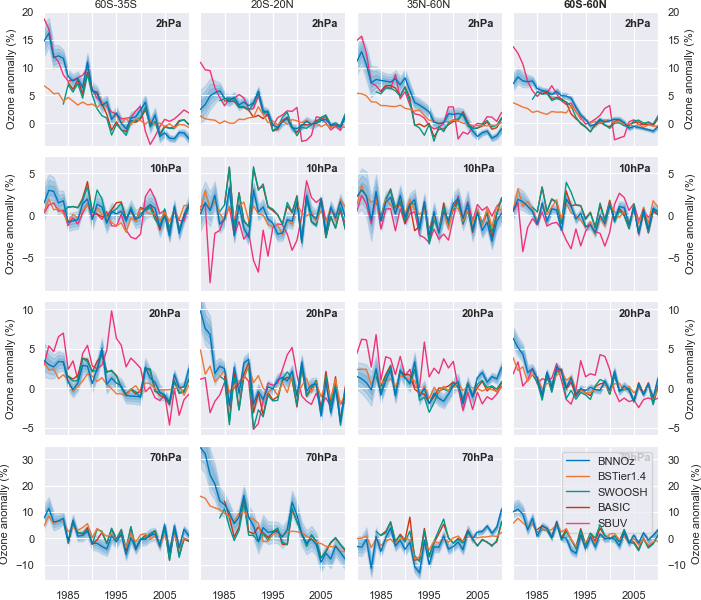

In [20]:
with plt.rc_context(dict(sns.axes_style("darkgrid"))):
    
    # Near global, 35-60N, 20-20 , 35-60S
    regions = [(6, 11), (14,22), (25, 30), (6, 30)]
    regions_basic = [(0,3), (4,8), (9,12), (0,12)]
    
    alpha_val = 0.9
    
    fig = plt.figure(figsize=(7, 6))
    
    # For 2 hPa
    plev_idx = 38
    plev_idx_sbuv = 10
    plev_idx_basic_wos = 22
    plev_idx_basic_ws = 8
    plev_idx_swoosh = 26
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
    print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
    print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Top row
    plot_row(row=0, ylim=[-4,20], plev_label='2hPa')
    
    # For 10hPa
    plev_idx = 27
    plev_idx_sbuv = 5
    plev_idx_basic_wos = 14
    plev_idx_basic_ws = 4
    plev_idx_swoosh = 18
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
    print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
    print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Second row
    plot_row(row=1, ylim=[-9,7], plev_label='10hPa')
    
    # For 20hPa
    plev_idx = 22
    plev_idx_sbuv = 3
    plev_idx_basic_wos = 10
    plev_idx_basic_ws = 2
    plev_idx_swoosh = 14
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
    print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
    print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Third row
    plot_row(row=2, ylim=[-6,11], plev_label='20hPa')
    
    # 70hPa
    plev_idx = 14
#     plev_idx_sbuv = 3
    plev_idx_basic_wos = 4
#     plev_idx_basic_ws = 1
    plev_idx_swoosh = 8
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
#     print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
#     print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Fourth row
    plot_row(row=3, ylim=[-16,35], plev_label='70hPa', exclude_low=True, bottom_row=True)
    plt.legend()
    
    plt.subplots_adjust(bottom=0., right=1., top=1., left=0., hspace=0.08, wspace=0.08)
    set_size(fig, (7, 6))
#     plt.tight_layout()
    plt.savefig('figures/paper3-fig3_near_global_real_unc.pdf', bbox_inches='tight', dpi=200)
    plt.savefig('figures/paper3-fig3_near_global_real_unc.png', bbox_inches='tight', dpi=200)
    
    plt.show()

Pressure level bdbp 2.177246756031777
Pressure level sbuv 2.0
Pressure level basic_wos 2.1544342041015625
Pressure level basic_ws 2.1544342041015625
Pressure level swoosh 2.1544346809387207
Pressure level bdbp 10.480220241473441
Pressure level sbuv 10.0
Pressure level basic_wos 10.0
Pressure level basic_ws 10.0
Pressure level swoosh 10.0
Pressure level bdbp 21.408229589608958
Pressure level sbuv 20.0
Pressure level basic_wos 21.544347763061523
Pressure level basic_ws 21.544349670410156
Pressure level swoosh 21.544347763061523
Pressure level bdbp 67.13010158602914
Pressure level basic_wos 68.12921142578125
Pressure level swoosh 68.12920379638672


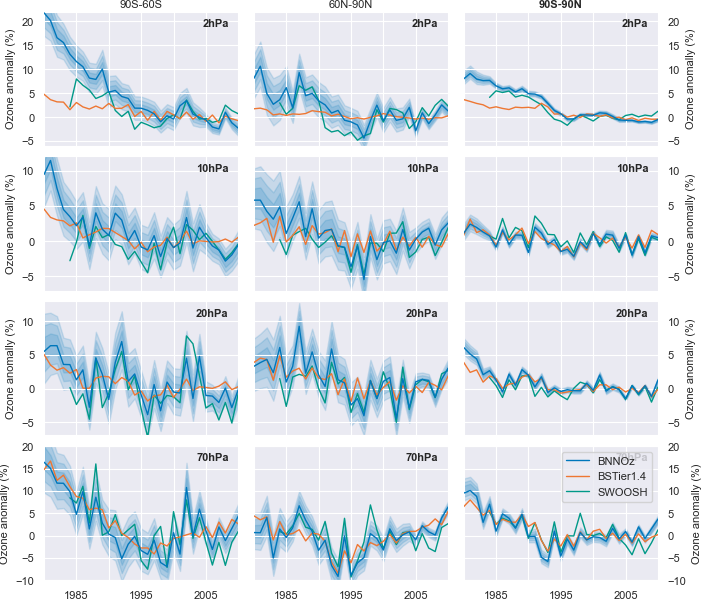

In [21]:
with plt.rc_context(dict(sns.axes_style("darkgrid"))):
    
    # Near global, 35-60N, 20-20 , 35-60S
    regions = [(0,6), (30,36), (0,36)]
    regions_basic = [False, False, False]
    
    alpha_val = 0.9
    
    fig = plt.figure(figsize=(7, 6))
    
    # For 2 hPa
    plev_idx = 38
    plev_idx_sbuv = 10
    plev_idx_basic_wos = 22
    plev_idx_basic_ws = 8
    plev_idx_swoosh = 26
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
    print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
    print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Top row
    plot_row(row=0, ylim=[-6,22], plev_label='2hPa', exclude_basic=True, near_global=False, poles=True, exclude_sbuv=True)
    
    # For 10hPa
    plev_idx = 27
    plev_idx_sbuv = 5
    plev_idx_basic_wos = 14
    plev_idx_basic_ws = 4
    plev_idx_swoosh = 18
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
    print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
    print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Second row
    plot_row(row=1, ylim=[-7,12], plev_label='10hPa', exclude_basic=True, poles=True, exclude_sbuv=True)
    
    # For 20hPa
    plev_idx = 22
    plev_idx_sbuv = 3
    plev_idx_basic_wos = 10
    plev_idx_basic_ws = 2
    plev_idx_swoosh = 14
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
    print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
    print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Third row
    plot_row(row=2, ylim=[-7,13], plev_label='20hPa', exclude_basic=True, poles=True, exclude_sbuv=True)
    
    # 70hPa
    plev_idx = 14
#     plev_idx_sbuv = 3
    plev_idx_basic_wos = 4
#     plev_idx_basic_ws = 1
    plev_idx_swoosh = 8
    
    print('Pressure level bdbp {}'.format(plev[plev_idx]))
#     print('Pressure level sbuv {}'.format(sbuv_plev[plev_idx_sbuv]))
    print('Pressure level basic_wos {}'.format(basic_wos_plev[plev_idx_basic_wos]))
#     print('Pressure level basic_ws {}'.format(basic_ws_plev[plev_idx_basic_ws]))
    print('Pressure level swoosh {}'.format(swoosh_plev[plev_idx_swoosh]))
    
    # Fourth row
    plot_row(row=3, ylim=[-10,20], plev_label='70hPa', exclude_low=True, exclude_basic=True, bottom_row=True, poles=True, exclude_sbuv=True)
    plt.legend()
    
    plt.subplots_adjust(bottom=0., right=1., top=1., left=0., hspace=0.08, wspace=0.08)
    set_size(fig, (7, 6))
#     plt.tight_layout()
    plt.savefig('figures/paper3-fig4_global_real_unc.pdf', bbox_inches='tight', dpi=200)
    plt.savefig('figures/paper3-fig4_global_real_unc.png', bbox_inches='tight', dpi=200)
    
    plt.show()